In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from copy import deepcopy
import numpy as np
import pytreenet as ptn
import random
from numpy.random import default_rng, Generator
from pytreenet.random import random_tensor_node
from fractions import Fraction
import matplotlib.pyplot as plt
import math



# Tree Tensor Network Operator for the Toy Model
In the main manuscript we consider a toy Hamiltonian to show the workings of our algorithm to find tree tensor network operators from a Hamiltonian. The toy Hamiltonian is defined on a tree structure as given in Fig.4.1a) in the main manuscript as
$$

H = \sum_{i,j} \frac{J}{\|i - j\|} X_i X_j + \sum_i g Z_i
$$
Here we want to show that our implemented algorithm yields the same state diagrams as the ones shown in the main text.

In [3]:
# Building the tree
def construct_reference_tree() -> ptn.TreeTensorNetworkState:
    """
    Generates the desired tree tensor network used as a reference to construct
     the Hamiltonian.
    """
    ttns = ptn.TreeTensorNetworkState()
    # Physical legs come last
    node1, tensor1 = random_tensor_node((1, 1, 2), identifier="site1")
    node2, tensor2 = random_tensor_node((1, 1, 1, 2), identifier="site2")
    node3, tensor3 = random_tensor_node((1, 2), identifier="site3")
    node4, tensor4 = random_tensor_node((1, 2), identifier="site4")
    node5, tensor5 = random_tensor_node((1, 1, 1, 2), identifier="site5")
    node6, tensor6 = random_tensor_node((1, 2), identifier="site6")
    node7, tensor7 = random_tensor_node((1, 1, 2), identifier="site7")
    node8, tensor8 = random_tensor_node((1, 2), identifier="site8")
    
    ttns.add_root(node1, tensor1)
    ttns.add_child_to_parent(node2, tensor2, 0, "site1", 0)
    ttns.add_child_to_parent(node3, tensor3, 0, "site2", 1)
    ttns.add_child_to_parent(node4, tensor4, 0, "site2", 2)
    ttns.add_child_to_parent(node5, tensor5, 0, "site1", 1)
    ttns.add_child_to_parent(node6, tensor6, 0, "site5", 1)
    ttns.add_child_to_parent(node7, tensor7, 0, "site5", 2)
    ttns.add_child_to_parent(node8, tensor8, 0, "site7", 1)
    return ttns

In [4]:
def construct_reference_tree_virtual() -> ptn.TreeTensorNetworkState:
    """
    Generates the desired tree tensor network used as a reference to construct
     the Hamiltonian.
    """
    ttns = ptn.TreeTensorNetworkState()
    # Physical legs come last
    node1, tensor1 = random_tensor_node((1, 1, 2), identifier="site1")
    virt1, v_tensor1 = random_tensor_node((1, 1 ), identifier="site1_v")
    node2, tensor2 = random_tensor_node((1, 2), identifier="site2")

    node4, tensor4 = random_tensor_node((1, 2), identifier="site4")
    
    
    ttns.add_root(node1, tensor1)
    ttns.add_child_to_parent(virt1, v_tensor1, 0, "site1", 0)
    ttns.add_child_to_parent(node4, tensor4, 0, "site1", 1)
    ttns.add_child_to_parent(node2, tensor2, 0, "site1_v", 1)
    
    return ttns
    

In [5]:
def construct_snake_like_tree(L: int) -> ptn.TreeTensorNetworkState:
    """
    Constructs a tree structure for an LxL grid where the grid is connected
    linearly in a snake-like pattern.
    
    Args:
        L (int): The size of the grid (LxL).
    
    Returns:
        ptn.TreeTensorNetworkState: The resulting tree tensor network state.
    """
    ttns = ptn.TreeTensorNetworkState()
    debug = False
    
    # Helper to create tensor nodes
    def create_node(identifier, shape):
        return random_tensor_node(shape, identifier=identifier)

    # Generate the grid as a snake-like traversal
    nodes = {}
    tensors = {}

    # Create nodes for the grid
    total_sites = L * L
    last_node = total_sites - 1 if L % 2 == 1 else total_sites - L
    for i in range(total_sites):
        site_id = f"site{i + 1}"
        if i == 0:  # Root node (only one child)
            node, tensor = create_node(site_id, (1, 2))
        elif i == last_node: # Last row (only one parent)  
            node, tensor = create_node(site_id, (1, 2))
        else:  # Intermediate nodes (one parent, one child)
            node, tensor = create_node(site_id, (1, 1, 2))
        nodes[site_id] = node
        tensors[site_id] = tensor

    # Add root (first site in the grid)
    root_site = "site1"
    ttns.add_root(nodes[root_site], tensors[root_site])

    # Connect the grid linearly in a snake-like pattern
    prev_site = root_site
    for i in range(L):
        row_sites = [f"site{L * i + j + 1}" for j in range(L)]
        if i % 2 == 1:  # Reverse the row for even-indexed rows (snake pattern)
            row_sites = row_sites[::-1]
        for site in row_sites:
            if site != prev_site:  # Skip the root
                # Use different child-parent indices for root and intermediate nodes
                if prev_site == root_site:
                    ttns.add_child_to_parent(nodes[site], tensors[site], 0, prev_site, 0)
                    if debug: print(f"Parent {prev_site} connected to Child {site}")
                else:
                    ttns.add_child_to_parent(nodes[site], tensors[site], 0, prev_site, 1)
                    if debug: print(f"Parent {prev_site} connected to Child {site}")
                prev_site = site

    return ttns

In [6]:
def construct_layered_tree(L: int) -> ptn.TreeTensorNetworkState:
    """
    Constructs a tree structure for an LxL grid where rows are connected sequentially,
    and the first element of each row connects to the each other.

    Args:
        L (int): The size of the grid (LxL).

    Returns:
        ptn.TreeTensorNetworkState: The resulting tree tensor network state.
    """
    ttns = ptn.TreeTensorNetworkState()
    debug = False

    # Helper to create tensor nodes with appropriate shape
    def create_node(identifier, shape):
        return random_tensor_node(shape, identifier=identifier)

    # Generate the grid
    nodes = {}
    tensors = {}

    # Create nodes for the grid
    total_sites = L * L
    for i in range(total_sites):
        site_id = f"site{i + 1}"
        if i == 0:  # Root node (only one child)
            node, tensor = create_node(site_id, (1, 1, 2))
        elif i % L == 0:  # First element of a new row (one parent, two child)
            if i == total_sites - L:
                node, tensor = create_node(site_id, (1, 1, 2))
            else:
                node, tensor = create_node(site_id, (1, 1, 1, 2))
        elif i % L == L - 1:  # Last node (only one parent)
            node, tensor = create_node(site_id, (1, 2))
        else:  # Intermediate nodes (one parent, one child)
            node, tensor = create_node(site_id, (1, 1, 2))
        nodes[site_id] = node
        tensors[site_id] = tensor

    # Add root (site 1)
    root_site = "site1"
    ttns.add_root(nodes[root_site], tensors[root_site])

    # Connect the tree as per the layered structure
    prev_site = root_site
    for i in range(L):
        if prev_site != root_site:
            prev_site = f"site{L * (i-1) + 1}"
        row_sites = [f"site{L * i + j + 1}" for j in range(L)]

        for site_idx, site in enumerate(row_sites):
            if site_idx == 0 and i > 0:  # Connect the first element of the row to the last element of the previous row
                if prev_site == root_site:
                    ttns.add_child_to_parent(nodes[site], tensors[site], 0, prev_site, 1)
                    if debug: print(f"Parent {prev_site} connected to Child {site}")

                else:
                    ttns.add_child_to_parent(nodes[site], tensors[site], 0, prev_site, 2)
                    if debug: print(f"Parent {prev_site} connected to Child {site}")

            elif site_idx > 0:  # Connect elements sequentially within the row
                if prev_site == root_site:
                    ttns.add_child_to_parent(nodes[site], tensors[site], 0, prev_site, 0)
                    if debug: print(f"Parent {prev_site} connected to Child {site}")

                else:
                    ttns.add_child_to_parent(nodes[site], tensors[site], 0, prev_site, 1)
                    if debug: print(f"Parent {prev_site} connected to Child {site}")

            else:
                continue
            prev_site = site

    return ttns

In [7]:
def construct_staircase_tree(L: int) -> ptn.TreeTensorNetworkState:
    """
    Constructs a tree structure for an LxL grid where nodes connected in a diagonal way.

    Args:
        L (int): The size of the grid (LxL).

    Returns:
        ptn.TreeTensorNetworkState: The resulting tree tensor network state.
    """
    ttns = ptn.TreeTensorNetworkState()
    debug = False

    # Helper to create tensor nodes with appropriate shape
    def create_node(identifier, shape):
        return random_tensor_node(shape, identifier=identifier)

    # Generate the grid
    nodes = {}
    tensors = {}

    # Create nodes for the grid
    total_sites = L * L
    for i in range(total_sites):
        site_id = f"site{i + 1}"
        
        if i % L == L-1:  # Last in a row
            node, tensor = create_node(site_id, (1, 2))
            if debug: print(f"site{i+1} : shape: {tensor.shape}")
        elif i % L == 0 and i >= 2*L :  # First in a row
            node, tensor = create_node(site_id, (1, 2))
            if debug: print(f"site{i+1} : shape: {tensor.shape}")
        elif (i // L  == i % L or i // L == i % L + 1 ) and i // L > 0 and i % L > 0 and i % L < L-1: # staircase nodes 
                node, tensor = create_node(site_id, (1, 1, 1, 2))
                if debug: print(f"site{i+1} : shape: {tensor.shape}")
        else:  # Intermediate nodes 
            node, tensor = create_node(site_id, (1, 1, 2))
            if debug: print(f"site{i+1} : shape: {tensor.shape}")
        nodes[site_id] = node
        tensors[site_id] = tensor

    # Add root (site 1)
    root_site = "site1"
    ttns.add_root(nodes[root_site], tensors[root_site])
    queue = [root_site]

    # Connect the tree as per the staircase structure
    while len(queue) > 0:
        
        current_node = queue.pop(0)
        current_row = (int(current_node[4:])-1) // L
        current_col = (int(current_node[4:])-1) % L
        vacant_dim = 1
        if current_node == root_site:
            vacant_dim = 0
        if debug: print(f"current_node: {current_node}, current_row: {current_row}, current_col: {current_col}")

        if current_col == current_row:
            if current_row < L-1:
                next_node = f"site{L*(current_row+1) + current_col+1}"
                
                ttns.add_child_to_parent(nodes[next_node], tensors[next_node], 0, current_node, vacant_dim)
                vacant_dim += 1
                queue.append(next_node)
            if current_col < L-1:
                next_node = f"site{L*current_row + current_col+2}"
                
                ttns.add_child_to_parent(nodes[next_node], tensors[next_node], 0, current_node, vacant_dim)
                vacant_dim += 1
                queue.append(next_node)
        elif current_row == current_col + 1:
            if current_col < L-1:
                next_node = f"site{L*current_row + current_col+2}"
                ttns.add_child_to_parent(nodes[next_node], tensors[next_node], 0, current_node, vacant_dim)
                vacant_dim += 1 
                queue.append(next_node)
            if current_col > 0:
                next_node = f"site{L*current_row + current_col}"
                ttns.add_child_to_parent(nodes[next_node], tensors[next_node], 0, current_node, vacant_dim)
                vacant_dim += 1
                queue.append(next_node)
            
        elif current_row < current_col :
            if current_col < L-1:
                next_node = f"site{L*current_row + current_col+2}"
                ttns.add_child_to_parent(nodes[next_node], tensors[next_node], 0, current_node, vacant_dim)
                vacant_dim += 1
                queue.append(next_node)
        elif current_row > current_col:
            if current_col > 0:
                next_node = f"site{L*current_row + current_col}"
                ttns.add_child_to_parent(nodes[next_node], tensors[next_node], 0, current_node, vacant_dim)
                vacant_dim += 1
                queue.append(next_node)
    

    return ttns

In [8]:
def construct_binary_tree(L: int) -> ptn.TreeTensorNetworkState:
    """
    Constructs a tree structure for an LxL grid with virtual nodes that forms a binary tree. Here we create nodes in a snake traverse
    and connect them in a binary tree structure.

    Args:
        L (int): The size of the grid (LxL).

    Returns:
        ptn.TreeTensorNetworkState: The resulting tree tensor network state.
    """
    ttns = ptn.TreeTensorNetworkState()
    debug = False

    # Helper to create tensor nodes with appropriate shape
    def create_node(identifier, shape):
        return random_tensor_node(shape, identifier=identifier)

    # Generate the grid
    nodes = {}
    tensors = {}

    # Create nodes for the grid
    total_sites = L * L
    for i in range(total_sites):
        site_id = f"site{i + 1}"
        node, tensor = create_node(site_id, (1, 2))
        nodes[site_id] = node
        tensors[site_id] = tensor
    
    # Create virtual nodes on the road

    G = L**2
    
    D_base = math.floor(math.log2(G))
    v_count = G - 1 # Comes from:  (2 ** D_base - 1) + (G - 2 ** D_base)

    process_list = []
    for i in range(1, L + 1):
        if i % 2 == 1:
            # Odd row: left to right
            process_list.extend(range((i - 1) * L + 1, i * L + 1))
        else:
            # Even row: right to left
            process_list.extend(range(i * L, (i - 1) * L, -1))
    next_process = 2*(G - 2**D_base)

    # Add root (site 1)
    root_site = "sitev1"
    node_v, tensor_v = create_node(root_site, (1, 1))
    ttns.add_root(node_v, tensor_v)
    i = 1
    queue = [root_site]

    while queue:
        current_site = queue.pop(0) 
        vacant_dim = 1
        if current_site == root_site:
            vacant_dim = 0
        
        for _ in range(2):
            if i < v_count :
                next_site = f"sitev{i + 1}"
                node_v, tensor_v = create_node(next_site, (1, 1, 1))
                ttns.add_child_to_parent(node_v, tensor_v, 0, current_site, vacant_dim)
                if debug: print(f"Parent {current_site} connected to Child {next_site}")
                vacant_dim += 1
                queue.append(next_site)
            else:
                next_site = f"site{process_list[next_process]}"
                next_process = (next_process + 1) % G
                
                ttns.add_child_to_parent(nodes[next_site], tensors[next_site], 0, current_site, vacant_dim)
                if debug: print(f"Parent {current_site} connected to Child {next_site}")
                vacant_dim += 1
        
            i += 1
        
    return ttns

In [9]:
def construct_binary_tree_alt(L: int) -> ptn.TreeTensorNetworkState:
    """
    Constructs a tree structure for an LxL grid with virtual nodes that forms a binary tree. Here we create nodes in a snake traverse
    and connect them in a binary tree structure.

    Args:
        L (int): The size of the grid (LxL).

    Returns:
        ptn.TreeTensorNetworkState: The resulting tree tensor network state.
    """
    ttns = ptn.TreeTensorNetworkState()
    debug = False

    # Helper to create tensor nodes with appropriate shape
    def create_node(identifier, shape):
        return random_tensor_node(shape, identifier=identifier)

    # Generate the grid
    nodes = {}
    tensors = {}

    # Create nodes for the grid
    total_sites = L * L
    for i in range(total_sites):
        site_id = f"site{i + 1}"
        node, tensor = create_node(site_id, (1, 2))
        nodes[site_id] = node
        tensors[site_id] = tensor
    
    # Create virtual nodes on the road

    G = L**2
    
    D_base = math.floor(math.log2(G))
    v_count = G - 1 # Comes from:  (2 ** D_base - 1) + (G - 2 ** D_base)

    process_list = list(range(1, G + 1))
    random.shuffle(process_list)
    next_process = 2*(G - 2**D_base)

    # Add root (site 1)
    root_site = "sitev1"
    node_v, tensor_v = create_node(root_site, (1, 1))
    ttns.add_root(node_v, tensor_v)
    i = 1
    queue = [root_site]

    while queue:
        current_site = queue.pop(0) 
        vacant_dim = 1
        if current_site == root_site:
            vacant_dim = 0
        
        for _ in range(2):
            if i < v_count :
                next_site = f"sitev{i + 1}"
                node_v, tensor_v = create_node(next_site, (1, 1, 1))
                ttns.add_child_to_parent(node_v, tensor_v, 0, current_site, vacant_dim)
                if debug: print(f"Parent {current_site} connected to Child {next_site}")
                vacant_dim += 1
                queue.append(next_site)
            else:
                next_site = f"site{process_list[next_process]}"
                next_process = (next_process + 1) % G
                
                ttns.add_child_to_parent(nodes[next_site], tensors[next_site], 0, current_site, vacant_dim)
                if debug: print(f"Parent {current_site} connected to Child {next_site}")
                vacant_dim += 1
        
            i += 1
        
    return ttns

In [10]:
def construct_layered_tree_with_virtual_nodes(L: int) -> ptn.TreeTensorNetworkState:
    """
    Constructs a tree structure for an LxL grid with virtual nodes that group rows hierarchically.

    Args:
        L (int): The size of the grid (LxL).

    Returns:
        ptn.TreeTensorNetworkState: The resulting tree tensor network state.
    """
    ttns = ptn.TreeTensorNetworkState()
    debug = False

    # Helper to create tensor nodes with appropriate shape
    def create_node(identifier, shape):
        return random_tensor_node(shape, identifier=identifier)

    # Generate the grid
    nodes = {}
    tensors = {}

    # Create physical nodes for the grid
    total_sites = L * L
    for i in range(total_sites):
        site_id = f"site{i + 1}"
          
        if i % L == L - 1:  # Last node (only one parent)
            node, tensor = create_node(site_id, (1, 2))
        else:  # Intermediate nodes (one parent, one child)
            node, tensor = create_node(site_id, (1, 1, 2))
        nodes[site_id] = node
        tensors[site_id] = tensor

    # Create virtual nodes for each layer
    
    for i in range(1,L-1):
        virtual_id = f"virtual{i + 1}"
        node, tensor = create_node(virtual_id, (1, 1, 1)) 
        nodes[virtual_id] = node
        tensors[virtual_id] = tensor

    # Add root (site1) and connect to the first virtual node
    root_site = "site1"
    ttns.add_root(nodes[root_site], tensors[root_site])
    prev_site = root_site

    if L == 2:
        ttns.add_child_to_parent(nodes["site2"], tensors["site2"], 0, "site1", 0)
        ttns.add_child_to_parent(nodes["site3"], tensors["site3"], 0, "site1", 1)
        ttns.add_child_to_parent(nodes["site4"], tensors["site4"], 0, "site3", 1)
        return ttns


    # Connect the tree using virtual nodes
    for i in range(L):
        
        row_sites = [f"site{L * i + j + 1}" for j in range(L)]
        virtual_id = f"virtual{i + 1}"

        if i > 0 and i < L-1:
            if i == 1:
                ttns.add_child_to_parent(nodes[virtual_id], tensors[virtual_id], 0, f"site{L * (i-1) + 1}", 1)
                if debug: print(f"parent site{L * (i-1) + 1} connected to site {virtual_id}")
            else: 
                ttns.add_child_to_parent(nodes[virtual_id], tensors[virtual_id], 0, f"virtual{i}", 2)
                if debug: print(f"parent virtual{i} connected to Child {virtual_id}")
            
            ttns.add_child_to_parent(nodes[f"site{L * (i) + 1}"], tensors[f"site{L * (i) + 1}"], 0, virtual_id, 1)
            if debug: print(f"parent {virtual_id} connected to child  site{L * (i) + 1} ")

            if i == L-2:
                ttns.add_child_to_parent(nodes[f"site{L * (i+1) + 1}"], tensors[f"site{L * (i+1) + 1}"], 0,virtual_id , 2)
                if debug: print(f"parent {virtual_id}  connected to site site{L * (i+1) + 1}")


        for site_idx, site in enumerate(row_sites):
            if site_idx > 0: 
                
                if prev_site == root_site:
                    ttns.add_child_to_parent(nodes[site], tensors[site], 0, prev_site, 0)
                    if debug: print(f"Parent {prev_site} connected to Child {site}")
                else:
                    ttns.add_child_to_parent(nodes[site], tensors[site], 0, prev_site, 1)
                    if debug: print(f"Parent {prev_site} connected to Child {site}")
            
            prev_site = site
            

    return ttns


In [11]:
def generate_grid(L):
    """Generate a grid of LxL sites and return a mapping from (x, y) to site labels."""
    grid = {}
    for x in range(L):
        for y in range(L):
            grid[(x, y)] = f"site{L * x + y + 1}"  # Label sites sequentially
    return grid

# Calculate Manhattan distance
def hamiltonian_distance(site1, site2, grid):
    """Compute Manhattan distance between two grid points."""
    coords = {v: k for k, v in grid.items()}  # Reverse mapping
    x1, y1 = coords[site1]
    x2, y2 = coords[site2]
    return abs(x1 - x2) + abs(y1 - y2)

def generate_hamiltonian(L, J, g):
    """Generate a symbolic Hamiltonian for an LxL grid."""
    grid = generate_grid(L)
    ham = []
    coeffs = []

    # Interaction term: J / ||i - j|| * X_i X_j
    for idx1, site1 in enumerate(grid.values()):
        for idx2, site2 in enumerate(grid.values()):
            if idx1 < idx2:  # Ensure unique pairs (i < j)
                distance = hamiltonian_distance(site1, site2, grid)
                term = {s: "I2" for s in grid.values()}  # Identity everywhere
                term[site1] = "X"
                term[site2] = "X"
                ham.append(term)
                coeffs.append((Fraction(1, distance), "J"))


    # Local field term: g * Z_i
    for site in grid.values():
        term = {s: "I2" for s in grid.values()}  # Identity everywhere
        term[site] = "Z"
        ham.append(term)
        coeffs.append((Fraction(1, 1), "g"))

    # Coefficient mapping
    coeffs_mapping = {"J": J, "g": g}

    return ham, coeffs_mapping, coeffs


In [12]:
def construct_hamiltonian(ham, coeffs_mapping, coeffs= None, ) -> ptn.Hamiltonian:

    if coeffs is None:
        coeffs = [1 for _ in range(len(ham))]
    
    paulis = ptn.pauli_matrices()
    conversion_dict = {"X": paulis[0], "Y": paulis[1], "Z": paulis[2], "I2": np.eye(2), "I1": np.eye(1)}
    return ptn.Hamiltonian([ptn.TensorProduct(i) for i in ham], conversion_dictionary=conversion_dict, coeffs=coeffs, coeffs_mapping=coeffs_mapping)


In [12]:
L = 5
J = 1
g = 1

In [49]:
ham, coeffs_mapping, coeffs = generate_hamiltonian(L, J, g)
#print(coeffs)

#for term, c in zip(ham, coeffs):
#    print(term, c)

#ttns_layered = construct_layered_tree(L)
#ttns_snake = construct_snake_like_tree(L)
#ttns_layered_v = construct_layered_tree_with_virtual_nodes(L)
#ttns_staircase = construct_staircase_tree(L)
ttns_binary = construct_binary_tree(L)

hamiltonian = construct_hamiltonian(ham, coeffs_mapping, coeffs)
hamiltonian_padded = hamiltonian.pad_with_identities(ttns_binary)

#ttns_virt = construct_reference_tree_virtual()
#virt_ham = [ {"site1": "X", "site4": "X"} ]
#virt_coeffs = [ (Fraction(1, 1), "1")]
#virt_coeffs_mapping = {"1": 1, "2": 1.345}
#virt_hamiltonian = construct_hamiltonian(virt_ham, virt_coeffs_mapping, virt_coeffs).pad_with_identities(ttns_virt)

### The Single Term Diagrams

In [50]:
for i, term in enumerate(hamiltonian_padded.terms):
    single_term_diag = ptn.SingleTermDiagram.from_single_term(term, ttns_binary)
    print(f"State Diagram for term {i}")
    print(single_term_diag)
    print("coeffs:", hamiltonian.coeffs[i])
    print("-----------------")

State Diagram for term 0
Hyperedges: {'sitev1': 'I1', 'sitev2': 'I1', 'sitev4': 'I1', 'sitev8': 'I1', 'sitev16': 'I1', 'site1': 'X', 'site2': 'X', 'sitev17': 'I1', 'site3': 'I2', 'site4': 'I2', 'sitev9': 'I1', 'sitev18': 'I1', 'site5': 'I2', 'site10': 'I2', 'sitev19': 'I1', 'site9': 'I2', 'site8': 'I2', 'sitev5': 'I1', 'sitev10': 'I1', 'sitev20': 'I1', 'site7': 'I2', 'site6': 'I2', 'sitev21': 'I1', 'site11': 'I2', 'site12': 'I2', 'sitev11': 'I1', 'sitev22': 'I1', 'site13': 'I2', 'site14': 'I2', 'sitev23': 'I1', 'site15': 'I2', 'site20': 'I2', 'sitev3': 'I1', 'sitev6': 'I1', 'sitev12': 'I1', 'sitev24': 'I1', 'site19': 'I2', 'site18': 'I2', 'site17': 'I2', 'sitev13': 'I1', 'site16': 'I2', 'site21': 'I2', 'sitev7': 'I1', 'sitev14': 'I1', 'site22': 'I2', 'site23': 'I2', 'sitev15': 'I1', 'site24': 'I2', 'site25': 'I2'}
Vertices: [('sitev1', 'sitev2'), ('sitev1', 'sitev3'), ('sitev2', 'sitev4'), ('sitev2', 'sitev5'), ('sitev4', 'sitev8'), ('sitev4', 'sitev9'), ('sitev8', 'sitev16'), ('sitev8

We can see that the single term diagrams are exactly the one we depicted in Fig. 4.1b).

### Complete State Diagram

In [51]:
state_diagram1 = ptn.StateDiagram.from_hamiltonian(hamiltonian_padded, ttns_binary, ptn.state_diagram.TTNOFinder.SGE)
print(len(state_diagram1.get_all_vertices()))
print(state_diagram1)
#print(state_diagram1.coeffs)
#ptn.TTNO.from_hamiltonian(hamiltonian1, ttns_root1)
#print(state_diagram1.coeffs, state_diagram1.coeffs_indices)


207
hyperedges:
label = I1; corr_site = sitev1; coeff = 1Free; connected to ('sitev1', 'sitev2'), ('sitev1', 'sitev3'), 
label = I1; corr_site = sitev1; coeff = 1Free; connected to ('sitev1', 'sitev2'), ('sitev1', 'sitev3'), 
label = I1; corr_site = sitev1; coeff = 1Free; connected to ('sitev1', 'sitev2'), ('sitev1', 'sitev3'), 
label = I1; corr_site = sitev1; coeff = 1Free; connected to ('sitev1', 'sitev2'), ('sitev1', 'sitev3'), 
label = I1; corr_site = sitev1; coeff = 1Free; connected to ('sitev1', 'sitev2'), ('sitev1', 'sitev3'), 
label = I1; corr_site = sitev1; coeff = 1Free; connected to ('sitev1', 'sitev2'), ('sitev1', 'sitev3'), 
label = I1; corr_site = sitev1; coeff = 1Free; connected to ('sitev1', 'sitev2'), ('sitev1', 'sitev3'), 
label = I1; corr_site = sitev1; coeff = 1Free; connected to ('sitev1', 'sitev2'), ('sitev1', 'sitev3'), 
label = I1; corr_site = sitev1; coeff = 1Free; connected to ('sitev1', 'sitev2'), ('sitev1', 'sitev3'), 
label = I1; corr_site = sitev1; coeff =

In [52]:
state_diagram2 = ptn.StateDiagram.from_hamiltonian(hamiltonian_padded,ttns_binary, ptn.TTNOFinder.TREE)
print(len(state_diagram2.get_all_vertices()))
print(state_diagram2)
#ptn.TTNO.from_hamiltonian(hamiltonian1, ttns_root1)


433
hyperedges:
label = I1; corr_site = sitev1; coeff = 1Free; connected to ('sitev1', 'sitev2'), ('sitev1', 'sitev3'), 
label = I1; corr_site = sitev1; coeff = 1Free; connected to ('sitev1', 'sitev2'), ('sitev1', 'sitev3'), 
label = I1; corr_site = sitev1; coeff = 1Free; connected to ('sitev1', 'sitev2'), ('sitev1', 'sitev3'), 
label = I1; corr_site = sitev1; coeff = 1Free; connected to ('sitev1', 'sitev2'), ('sitev1', 'sitev3'), 
label = I1; corr_site = sitev1; coeff = 1Free; connected to ('sitev1', 'sitev2'), ('sitev1', 'sitev3'), 
label = I1; corr_site = sitev1; coeff = 1Free; connected to ('sitev1', 'sitev2'), ('sitev1', 'sitev3'), 
label = I1; corr_site = sitev1; coeff = 1Free; connected to ('sitev1', 'sitev2'), ('sitev1', 'sitev3'), 
label = I1; corr_site = sitev1; coeff = 1Free; connected to ('sitev1', 'sitev2'), ('sitev1', 'sitev3'), 
label = I1; corr_site = sitev1; coeff = 1Free; connected to ('sitev1', 'sitev2'), ('sitev1', 'sitev3'), 
label = I1; corr_site = sitev1; coeff =

### Compare tensor values

In [47]:
def _find_permutation_rec(ttno, leg_dict, node_id, perm):
    node, _ = ttno[node_id]
    input_index = leg_dict[node_id]
    output_index = input_index + len(ttno.nodes)
    perm.extend([output_index, input_index ])
    if not node.is_leaf():
        for child_id in node.children:
            _find_permutation_rec(ttno, leg_dict, child_id, perm)

In [25]:
def _find_permutation_rec_not_v(ttno, leg_dict, node_id, perm):
    node, _ = ttno[node_id]
    
    if "v" not in node_id:
        input_index = leg_dict[node_id]
        output_index = input_index + len(leg_dict)
        perm.extend([output_index, input_index ])

    if not node.is_leaf():
        for child_id in node.children:
            _find_permutation_rec_not_v(ttno, leg_dict, child_id, perm)

In [89]:
#leg_dict = {f"site{i+1}": i for i in range(L*L)}
snake = False
single_term_diag = ptn.SingleTermDiagram.from_single_term(hamiltonian.terms[0], ttns_staircase)
leg_dict = {x.corr_node_id: i for i, x in enumerate(single_term_diag.get_all_hyperedges())}
#leg_dict = {site: i for i, site in enumerate(hamiltonian.terms[0].keys())}
print(leg_dict)

original_tensor = hamiltonian.to_tensor(ttns_staircase).operator

ttno = ptn.TTNO.from_hamiltonian(hamiltonian, ttns_staircase, ptn.state_diagram.TTNOFinder.BASE)



contructed_tensor,order = ttno.completely_contract_tree(to_copy=True)
print("order: ", order)

permutation = []
_find_permutation_rec(ttno, leg_dict, ttno.root_id, permutation)

print(permutation)
correct_tensor = original_tensor.transpose(permutation)



print("Equality: ", np.allclose(correct_tensor,contructed_tensor))
#print(original_tensor)
print("---------------------------")
#print(contructed_tensor)

{'site1': 0, 'site3': 1, 'site4': 2, 'site2': 3}
order:  ['site1', 'site3', 'site4', 'site2']
[4, 0, 5, 1, 6, 2, 7, 3]
Equality:  False
---------------------------


In [ ]:
#leg_dict = {f"site{i+1}": i for i in range(L*L)}
single_term_diag = ptn.SingleTermDiagram.from_single_term(virt_hamiltonian.terms[0], ttns_virt)

#vn = single_term_diag.get_all_hyperedges().copy()
#leg_dict = {}

#counter = 0
#for i in vn:
#    if "v" not in i.corr_node_id:
#        leg_dict[i.corr_node_id] = counter
#        counter += 1


leg_dict = {x.corr_node_id: i for i, x in enumerate(single_term_diag.get_all_hyperedges())}
#leg_dict = {site: i for i, site in enumerate(hamiltonian_padded.terms[0].keys())}
print(leg_dict)


original_tensor = virt_hamiltonian.to_tensor(ttns_virt).operator

ttno = ptn.TTNO.from_hamiltonian(virt_hamiltonian, ttns_virt, ptn.state_diagram.TTNOFinder.BASE)



contructed_tensor, order = ttno.completely_contract_tree(to_copy=True)
print(order)

permutation = []
_find_permutation_rec(ttno, leg_dict, ttno.root_id, permutation)
print(permutation)
permutation = [4, 0, 5, 1, 6, 2, 7, 3]


print(original_tensor.shape)
correct_tensor = original_tensor.transpose(permutation)

print("Original Tensor (sample):", original_tensor.flatten())
print("Constructed Tensor (sample):", contructed_tensor.flatten())
print("Correct Tensor (sample):", correct_tensor.flatten())

print("Equality: ", np.allclose(correct_tensor,contructed_tensor))
#print(original_tensor)
print("---------------------------")
#print(contructed_tensor)

{'site1': 0, 'site2': 1, 'site4': 2}
['site1', 'site1_v', 'site2', 'site4']
[3, 0, 4, 1, 5, 2]
(2, 2, 2, 2, 2, 2)
Original Tensor (sample): [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Constructed Tensor (sample): [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 1.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j
 1.+0.j 0.+0.j 0.+0.j 1.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.

One can see that this state diagram corresponds to the state diagram given in Fig. 4.1c) in the main text.

In [13]:
def obtain_bond_dimensions(ttno: ptn.TTNO) -> np.ndarray:
    """
    Obtains the bond dimensions of a TTN.

    Args:
        ttno (ptn.TTNO): The TTN for which to determine the bond dimensions.

    Returns:
        np.ndarray: A 1D-array containing all bond-dimensions
    """
    dimensions = []
    for node_id in ttno.nodes:
        node = ttno.nodes[node_id]
        if not node.is_root():
            dimensions.append(node.parent_leg_dim())

    if dimensions == []:
        return np.asarray([1])
    return np.asarray(dimensions)

In [12]:
leg_dict = {"site1": 0, "site2": 1, "site3": 2, "site4": 3, "site5": 4,
                "site6": 5, "site7": 6, "site8": 7,"site9": 8}
ttno_ham = ptn.TTNO.from_hamiltonian(hamiltonian1, ttns_root1)
total_tensor = hamiltonian1.to_tensor(ttns_root1).operator
ttno_svd = ptn.TTNO.from_tensor(ttns_root1,
                                total_tensor,
                                leg_dict,
                                mode=ptn.Decomposition.tSVD)
ham_dim = obtain_bond_dimensions(ttno_ham)
svd_dim = obtain_bond_dimensions(ttno_svd)

print("ham_dim",ham_dim,"svd_dim", svd_dim)
if np.any(ham_dim > svd_dim):
    print(ham_dim, svd_dim)

ham_dim [1 1 1 1 1 1 1] svd_dim [1 1 1 1 1 1 1]


## Experiment

In [16]:
rng = default_rng(seed=421142)

L_values = np.arange(2, 6)

ttns_structures = [
    construct_snake_like_tree, 
    construct_layered_tree,   
    construct_layered_tree_with_virtual_nodes,
    construct_staircase_tree,
    construct_binary_tree,
    construct_binary_tree_alt
]
ttns_names = ["MPS Case Snake Like Tree", "Layered Tree", "Layered Tree with Virtual Nodes", "Staircase Tree", "Binary Tree", "Binary Tree Inefficient"] # Add names corresponding to ttn_structures

# Collecting mean and max bond dimensions for each TTN structure
results_mean = {name: [] for name in ttns_names}
results_max = {name: [] for name in ttns_names}
results_raw = {name: [] for name in ttns_names}

for L in L_values:
    J, g = rng.uniform(-2, 2, 2)
    
    hamiltonian = construct_hamiltonian(*generate_hamiltonian(L, J, g))
    
    for name, ttn_func in zip(ttns_names, ttns_structures):
        ttns = ttn_func(L)  # Generate TTN structure

        hamiltonian_process = hamiltonian.pad_with_identities(ttns)

        ttno = ptn.TTNO.from_hamiltonian(hamiltonian_process, ttns, method=ptn.state_diagram.TTNOFinder.BIPARTITE)  # Generate TTNO from Hamiltonian
        bond_dimensions = obtain_bond_dimensions(ttno)
        
        # Collect mean and max bond dimensions
        results_raw[name].append(bond_dimensions)
        results_mean[name].append(np.mean(bond_dimensions))
        results_max[name].append(np.max(bond_dimensions))    
                                              
    print("Grid size: ", L, " is done.")
        

Grid size:  2  is done.
Grid size:  3  is done.
Grid size:  4  is done.
Grid size:  5  is done.


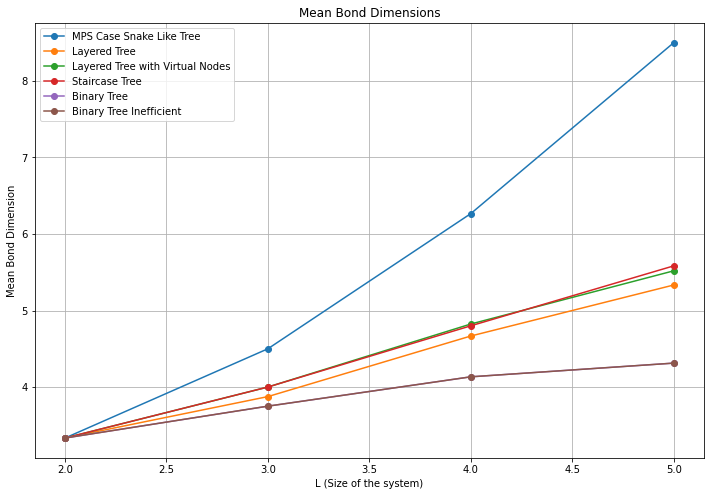

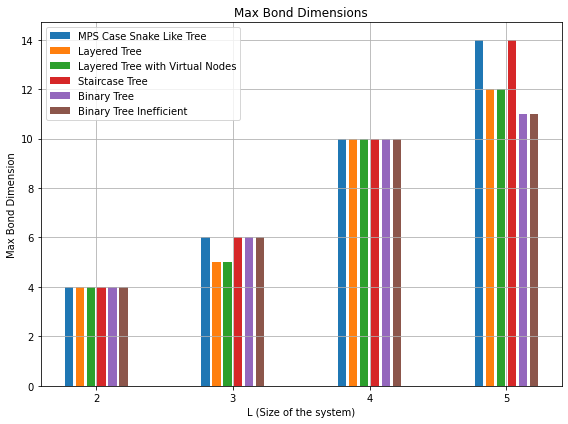

In [17]:
# Plotting the results
plt.figure(figsize=(12, 8))
markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'X', '<', '>']


# Mean bond dimensions

for name in ttns_names:
    plt.plot(L_values, results_mean[name], label=name, marker='o')
plt.title("Mean Bond Dimensions")
plt.xlabel("L (Size of the system)")
plt.ylabel("Mean Bond Dimension")
plt.legend()
plt.grid(True)

# Max bond dimensions
plt.figure(figsize=(8, 6))
bar_width = 0.08
x_positions = np.arange(len(L_values))
for i, name in enumerate(ttns_names):
    offset = i * bar_width
    plt.bar(x_positions + offset, results_max[name], width=bar_width-0.02, label=name)
plt.xticks(x_positions + bar_width * (len(ttns_names) - 1) / 2, L_values)

    
plt.title("Max Bond Dimensions")
plt.xlabel("L (Size of the system)")
plt.ylabel("Max Bond Dimension")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [182]:
# SGE Results:

SGE_results_mean = results_mean
SGE_results_max = results_max
SGE_results_raw = results_raw

https://github.com/qc-tum/chemtensor/blob/main/examples/op_chains/op_chains_ttno.ipynb